Student name: Nicholas Murphy

Student ID: 21268819

In [47]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
#from scipy import interp
import pickle
import matplotlib.pyplot as plt
from sklearn import neighbors
%matplotlib inline

## Task 1
Download the files - ✅ 

In [48]:
df = pd.read_csv("./seeds.csv")
df.head()

area  perimeter  compactness  length of kernel  width of kernel  \
0  15.26      14.84       0.8710             5.763            3.312   
1  14.88      14.57       0.8811             5.554            3.333   
2  14.29      14.09       0.9050             5.291            3.337   
3  13.84      13.94       0.8955             5.324            3.379   
4  16.14      14.99       0.9034             5.658            3.562   

   asymmetry coefficient  length of kernel groove  type  
0                  2.221                    5.220     1  
1                  1.018                    4.956     1  
2                  2.699                    4.825     1  
3                  2.259                    4.805     1  
4                  1.355                    5.175     1

In [49]:
df.tail()

area  perimeter  compactness  length of kernel  width of kernel  \
205  12.19      13.20       0.8783             5.137            2.981   
206  11.23      12.88       0.8511             5.140            2.795   
207  13.20      13.66       0.8883             5.236            3.232   
208  11.84      13.21       0.8521             5.175            2.836   
209  12.30      13.34       0.8684             5.243            2.974   

     asymmetry coefficient  length of kernel groove  type  
205                  3.631                    4.870     3  
206                  4.325                    5.003     3  
207                  8.315                    5.056     3  
208                  3.598                    5.044     3  
209                  5.637                    5.063     3

## Save the dataframe 


In [50]:
df_copy = df.copy()

## Task 2
Replicate the classifier training and evaluation demonstrated in the example notebook Lab 4 - Comparison of Binary Classifiers.ipynb but with the dataset seeds.csv. 

* You will need to formulate a binary classification problem and transform the type column accordingly. - ✅ 
* Summarise your conclusions (max 200 words in a markdown cell).


In [51]:
df['type'].value_counts()

1    70
2    70
3    70
Name: type, dtype: int64

In [52]:
df.isna().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

### Binary classifier
We need to be able to make a binary classification on the type column, but we have three values? What should we do in this circumstance. In cases like this we focus on one value (our "1") and reclassify all other values to be "0". 

I'm going to concentrate on type 3 here, collapsing types 1 and 2 together. No particular reason, other than a choice had to be made.

### the cost of misclassification.
When we classify based on our predictor columns we want to get as many **true positives** and as few **false negatives** as possible. Misclassification can have serious ramifications if the dependent variable is cancer diagnosis or an indication of metal fatigue. The dataset we're looking at is seeds, so maybe not as life or death as cancer prognosis. Even here though, if we are trying to identify drought resistent crops, a misclassification could result in a failed harvest.


We're using **precision_recall_fscore_support** to calculate the recall of the classifier where recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples

In [53]:
mapper = {1: 0, 2: 0, 3 : 1}
df['type'] = df['type'].replace(mapper)
df['type'].value_counts()

0    140
1     70
Name: type, dtype: int64

### Check for outliers

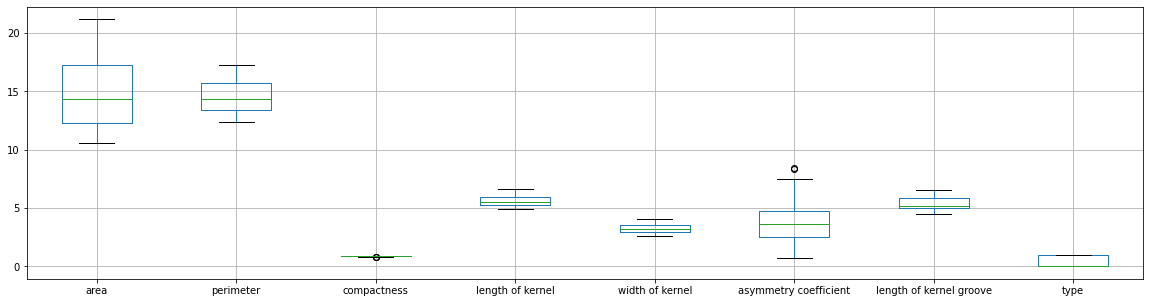

In [54]:
df.boxplot(figsize=(20,5))
plt.show()

The only noticable column with outliers is asymmetry coefficient, so I'll use robust scaler on that and Standard Scaler on all the rest.

In [55]:
# store a list with the names of all predictors
names_all = [c for c in df if c not in ['type']]

# define column groups with same data preparation
names_outliers = ['asymmetry coefficient']
names_no_outliers = list(set(names_all) - set(names_outliers))

In [56]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

In [57]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            StandardScaler()
        ))
    ])
)

### Split the data into train/test

In [58]:
y = df['type']
X = df.drop('type', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

### SVM classifier
Using much the same parameters as in the example. I've added sigmoid, just to see does it make a difference.

In [59]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability=True, ))])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of svn.SVC and their possible values

param_grid = {
    'svm__C': [0.01, 0.1, 1, 10, 100],  
    'svm__gamma': [1, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly','sigmoid']}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train) #trainign happens here! SVM is trained 240 times
#Julia

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.964:
Best parameters:  {'svm__C': 1, 'svm__gamma': 1, 'svm__kernel': 'poly'}


### Random forest
Again, using much the same parameters as were used in the example.

In [60]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of RandomForestClassifier and their possible values
param_grid = {
    'rf__n_estimators' : [10,20,30],
    'rf__max_depth': [2, 4, 6, 8]
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.964:
Best parameters:  {'rf__max_depth': 4, 'rf__n_estimators': 20}


## Task 3 - Train a third classifier
## K Nearest neighbour
I've picked K Nearest Neighbour for the additional classifier, and I've loaded up the parameter grid with a comprehensive list of parameters to exercise it.

In [61]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('knn', neighbors.KNeighborsClassifier(n_neighbors=5))])

param_grid = {
    'knn__n_neighbors' :[3,4,5,6,7,8,9],
    'knn__weights' :['uniform','distance'],
    'knn__p' :[1,2],
    'knn__algorithm' :['auto','ball_tree','kd_tree','brute'],
    'knn__leaf_size' :[10,20,30,40,50,60],
    }

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train) 

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
KNN_best_params = search.best_params_
KNN_best_model = search.best_estimator_

Best CV score = 0.964:
Best parameters:  {'knn__algorithm': 'auto', 'knn__leaf_size': 10, 'knn__n_neighbors': 5, 'knn__p': 1, 'knn__weights': 'uniform'}


## Compare Classifiers on Test Set

Now we can evaluate the best models found by the grid search on the test dataset and compare their results (accuracy, precision, recall, etc.) to choose the better classifier for our problem.

The evaluation function below evaluates a model on a test data set. Note that, the preprocessing pipeline will be automatically applied to the test set. The results returned by the function are a variety of metrics measured on the test set which we will use to compare the models and decide which classifier to choose for training the final model. These metrics are:

- accuracy
- precisions
- recall
- F1-score
- TPR (true positive rate)
- AUC (area under the ROC curve)

To plot ROC curves for the models, we need to ensure that the same fpr (false positive rate) scale is used for all curves. For this reason, we take a scale of 100 equally spaced fpr values between 0 and 1.

In [62]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [63]:
# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the classifier learns to predict probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
    _auc = auc(_fpr, _tpr)

    #print ("True positive rate : {tpr}, False Positive Rate: {fpr}, area under curve = {auc}".format(tpr=_tpr, fpr=_fpr,auc=_auc))
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

In [64]:
def evaluate_model_over_X_iterations(X_test, y_test, model, num_iterations):
    """ runs the evaluate model multiple times and averages out the results
    """

    total_accuracy = total_precision = total_recall = total_f1_score = total_tpr = total_auc = 0.0
    for i in range(num_iterations):
        accuracy, precision, recall, f1_score, tpr, auc = evaluate_model(X_test, y_test, model)
        total_accuracy += accuracy
        total_precision += precision
        total_recall += recall
        total_f1_score += f1_score
        total_tpr += tpr
        total_auc += auc

    return total_accuracy/num_iterations, total_precision/num_iterations, total_recall/num_iterations, total_f1_score/num_iterations, total_tpr/num_iterations, total_auc/num_iterations

In [65]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model_over_X_iterations(X_test, y_test, SVM_best_model,num_iterations=4)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model_over_X_iterations(X_test, y_test, RF_best_model,num_iterations=4)
KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score, KNN_tpr, KNN_auc = evaluate_model_over_X_iterations(X_test, y_test, KNN_best_model,num_iterations=4)


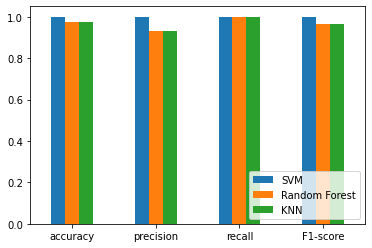

SVM recall: 1.0, RF recall: 1.0, KNN recall: 1.0


In [66]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
KNN_metrics = np.array([KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics, 'KNN':KNN_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

print ("SVM recall: {svm}, RF recall: {rf}, KNN recall: {knn}".format(svm=SVM_recall, rf=RF_recall,knn=KNN_recall))

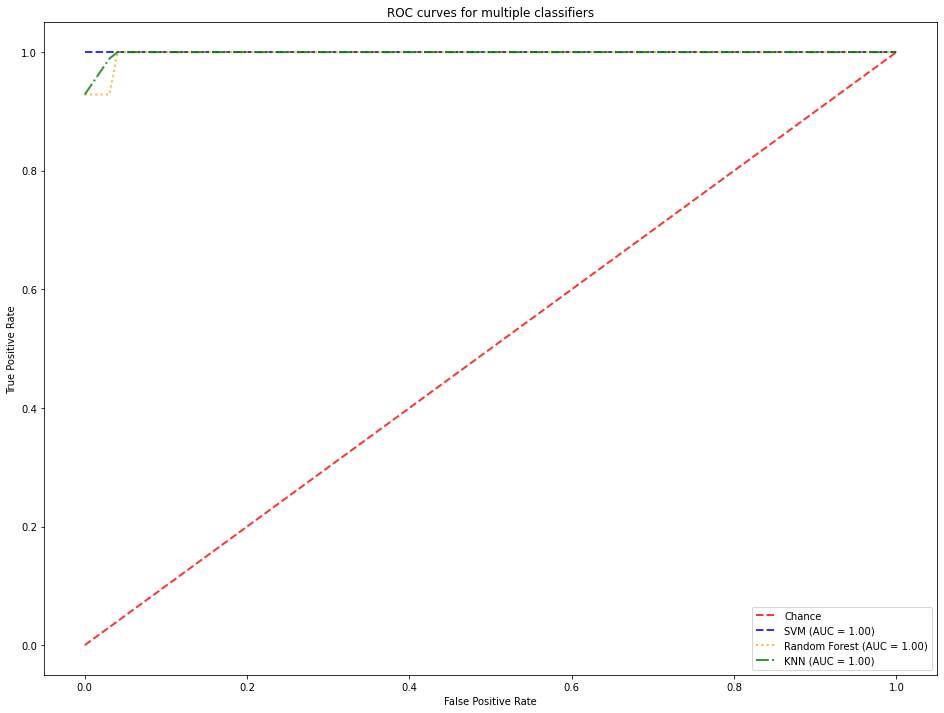

In [67]:
plt.figure(figsize=(16,12))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue',  linestyle='--', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', linestyle=':', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_fpr, KNN_tpr[0,:], lw=2, color='green', linestyle='-.', label='KNN (AUC = %0.2f)' % (KNN_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

## Conclusions - Task 2 and 3 

All three clasifiers - SVM, Random Forest and Nearest Neighbors perform very well, far above random chance. Values flucuate between runs, with recall dropping to 78% for Random Forest in one case. However for the current run recall is at 100% for all cases. From observation of previous runs, my observation is that KNN seems to be the more robust classifier, always in the 90s, whereas both SVM and RF have been seen to drop down on some runs. Overall though, any of these classifiers would be satisfactory for the purposes of this dataset

# Conclusion - Task 3 - KNN Parameters
In order to get the best results from KNN, I'm using a parammap dictionary into which I'm putting various values for number of neighbours, weight function, which algorithm to use, what leafsize and power parameter, based on the reference page in scikitlearn. I'm not using them all, and to be honest I'm not entirely sure what they all do. However, by providing a range, GridSearchCV will apply each variation and return the best results.

In [68]:
# function to remove the string 'svm__' from the names of the parameters in SVM_best_params
def transform(dict):
    return {key.replace('svm__','') :  value for key, value in dict.items()}

pipe = make_pipeline(preprocess_pipeline, svm.SVC(**transform(SVM_best_params)))

final_model =pipe.fit(X, y)

In [69]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))